Load/format data, do any necessary preprocessing and EDA in this notebook.

In [1]:
%matplotlib inline

import glob
import xarray as xr
import rioxarray
import pandas as pd
import numpy as np
from datetime import datetime
import re
import matplotlib.pyplot as plt

def paths_to_datetimeindex(paths):
    """
    Extract the FIRST date from each filename and return a pandas.DatetimeIndex.
    string_slice should give the full date range substring.
    Example substring: '20190606-20190622'
    """
    labels = []
    for p in paths:
        fname = p.split('/')[-1]
        dates = re.findall(r"\d{8}", fname)
        if len(dates) < 2:
            raise ValueError(f"File does not contain two dates: {fname}")
        start = pd.to_datetime(dates[0]).strftime("%Y-%m-%d")
        end = pd.to_datetime(dates[1]).strftime("%Y-%m-%d")
        labels.append(f"{start} – {end}")  # use en dash for readability
    return labels

def midpoint(t):
    # Extract all YYYY MM DD patterns
    nums = re.findall(r"\d{4}\d{2}\d{2}", t.replace("-", ""))
    
    if len(nums) == 2:
        d1 = pd.to_datetime(nums[0])
        d2 = pd.to_datetime(nums[1])
        return d1 + (d2 - d1) / 2
    else:
        return pd.NaT

In [2]:
geotiff_list = glob.glob('data/Karakoram/*.tif')

# Create variable used for time axis
time_var = xr.Variable('time', paths_to_datetimeindex(geotiff_list))

# Load in and concatenate all individual GeoTIFFs
geotiffs_da = xr.concat(
    [rioxarray.open_rasterio(i) for i in geotiff_list],
    dim=time_var
)

# Covert our xarray.DataArray into a xarray.Dataset
geotiffs_ds = geotiffs_da.to_dataset('band')

# Rename the variable to a more useful name
geotiffs_ds = geotiffs_ds.rename({1: 'x_vel', 2: 'y_vel', 3: 'vel_magnitude'})

#Adding midpoint time for sorting
mid_times = [midpoint(t) for t in geotiffs_ds.time.values]
geotiffs_ds = geotiffs_ds.assign_coords(mid_time=("time", mid_times))
geotiffs_ds = geotiffs_ds.sortby("mid_time")

# Print the output
geotiffs_ds

<xarray.Dataset> Size: 70MB
Dimensions:        (time: 81, y: 231, x: 310)
Coordinates:
  * x              (x) float64 2kB 7.11e+05 7.111e+05 ... 7.418e+05 7.419e+05
  * y              (y) float64 2kB 3.924e+06 3.924e+06 ... 3.902e+06 3.901e+06
    spatial_ref    int64 8B 0
  * time           (time) <U23 7kB '2019-03-18 – 2019-04-03' ... '2020-05-22 ...
    mid_time       (time) datetime64[ns] 648B 2019-03-26 ... 2020-05-24T12:00:00
Data variables:
    x_vel          (time, y, x) float32 23MB nan nan nan nan ... nan nan nan nan
    y_vel          (time, y, x) float32 23MB nan nan nan nan ... nan nan nan nan
    vel_magnitude  (time, y, x) float32 23MB nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

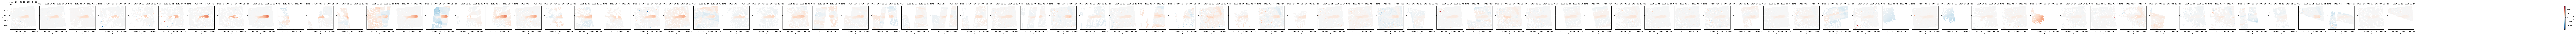

In [3]:
geotiffs_ds.x_vel.plot(col='time')

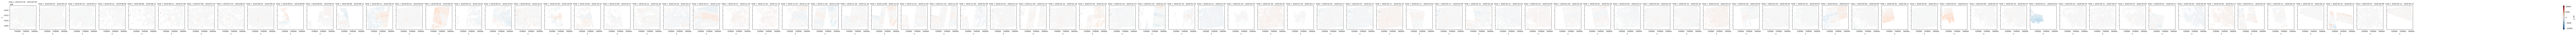

In [4]:
geotiffs_ds.y_vel.plot(col='time')

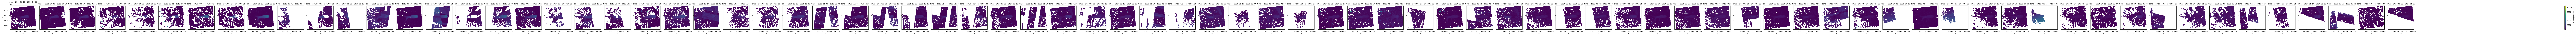

In [5]:
geotiffs_ds.vel_magnitude.plot(col='time')

In [6]:
for var in geotiffs_ds.data_vars:
    non_nan_count = geotiffs_ds[var].count().values  # counts non-NaN along all dims
    total_count = geotiffs_ds[var].size
    print(f"{var}: {non_nan_count} / {total_count} non-NaN values")

x_vel: 3044019 / 5800410 non-NaN values
y_vel: 3044019 / 5800410 non-NaN values
vel_magnitude: 3044019 / 5800410 non-NaN values


About half of the coordinates have no data on average

In [7]:
print("Overall Velocities' Summary Statistics")

for var in geotiffs_ds.data_vars:
    print(var)
    print("min:", geotiffs_ds[var].min().values)
    print("max:", geotiffs_ds[var].max().values)
    print("mean:", geotiffs_ds[var].mean().values)
    print("median:", geotiffs_ds[var].median().values)
    print()

Overall Velocities' Summary Statistics
x_vel
min: -7242.9688
max: 7131.9233
mean: 58.73337
median: 5.3466797

y_vel
min: -7037.6562
max: 10950.0
mean: 15.866872
median: 6.3275137

vel_magnitude
min: 0.0
max: 10976.636
mean: 366.65338
median: 206.13287



In [9]:
mean_vx = geotiffs_ds.x_vel.mean(dim=['x','y'])
mean_vy = geotiffs_ds.y_vel.mean(dim=['x','y'])
mean_speed = geotiffs_ds.vel_magnitude.mean(dim=['x','y'])

summary_df = pd.DataFrame({
    'time': geotiffs_ds.time.values,
    'midpoint' : geotiffs_ds.mid_time.values,
    'mean_vx': mean_vx.values,
    'mean_vy': mean_vy.values,
    'mean_vel_magnitude': mean_speed.values})
summary_df

time            midpoint     mean_vx     mean_vy  \
0   2019-03-18 – 2019-04-03 2019-03-26 00:00:00   31.070816  -27.238939   
1   2019-04-03 – 2019-04-19 2019-04-11 00:00:00   35.301289   12.930854   
2   2019-04-19 – 2019-05-21 2019-05-05 00:00:00  108.520485  -29.038946   
3   2019-05-21 – 2019-06-06 2019-05-29 00:00:00   28.561535  -14.863124   
4   2019-06-06 – 2019-06-22 2019-06-14 00:00:00   35.434811   25.728876   
..                      ...                 ...         ...         ...   
76  2020-05-11 – 2020-05-25 2020-05-18 00:00:00  -79.549194   34.230068   
77  2020-05-14 – 2020-05-22 2020-05-18 00:00:00  -71.950104   -7.211371   
78  2020-05-16 – 2020-05-22 2020-05-19 00:00:00 -236.666458  216.467209   
79  2020-05-07 – 2020-06-08 2020-05-23 00:00:00   18.800703    6.324749   
80  2020-05-22 – 2020-05-27 2020-05-24 12:00:00   57.135376  114.668678   

    mean_vel_magnitude  
0           158.897003  
1           141.212631  
2           154.400253  
3           186.832336  
4           262.479065  
..                 ...  
76          278.699402  
77          259.387482  
78          637.815491  
79           99.088524  
80          191.970840  

[81 rows x 5 columns]

^Time Series Data 👀

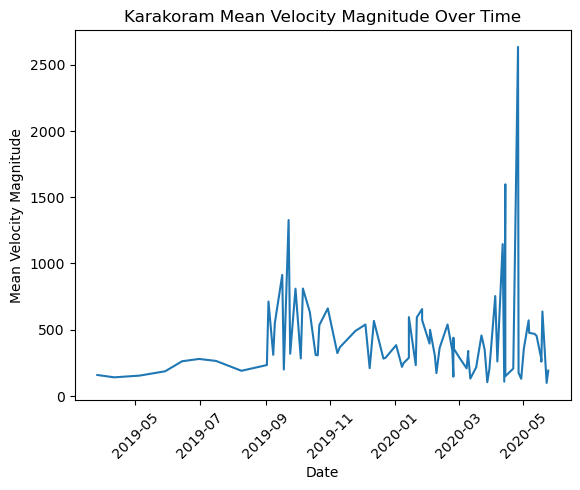

In [10]:
plt.figure()
plt.plot(summary_df['midpoint'], summary_df['mean_vel_magnitude'])
plt.xticks(rotation=45) 
plt.xlabel('Date')
plt.ylabel('Mean Velocity Magnitude')
plt.title('Karakoram Mean Velocity Magnitude Over Time')
plt.show()

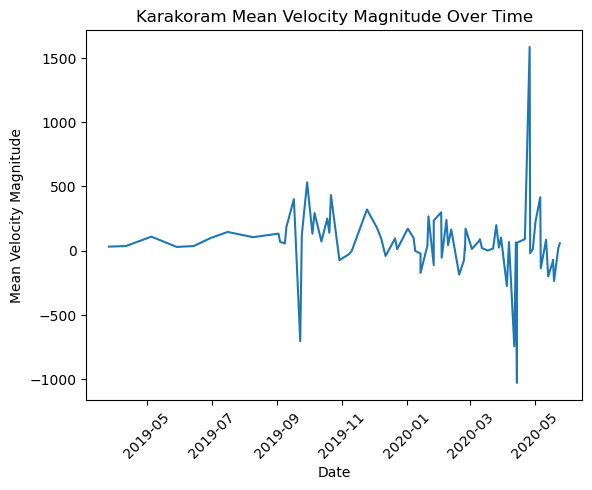

In [12]:
plt.figure()
plt.plot(summary_df['midpoint'], summary_df['mean_vx'])
plt.xticks(rotation=45) 
plt.xlabel('Date')
plt.ylabel('Mean Velocity Magnitude')
plt.title('Karakoram Mean Velocity Magnitude Over Time')
plt.show()

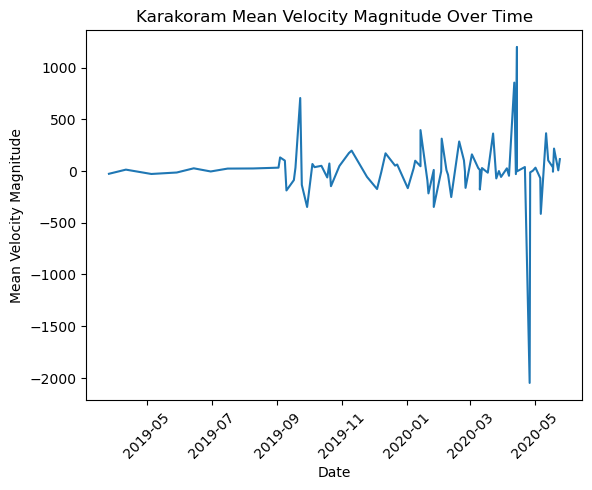

In [13]:
plt.figure()
plt.plot(summary_df['midpoint'], summary_df['mean_vy'])
plt.xticks(rotation=45) 
plt.xlabel('Date')
plt.ylabel('Mean Velocity Magnitude')
plt.title('Karakoram Mean Velocity Magnitude Over Time')
plt.show()

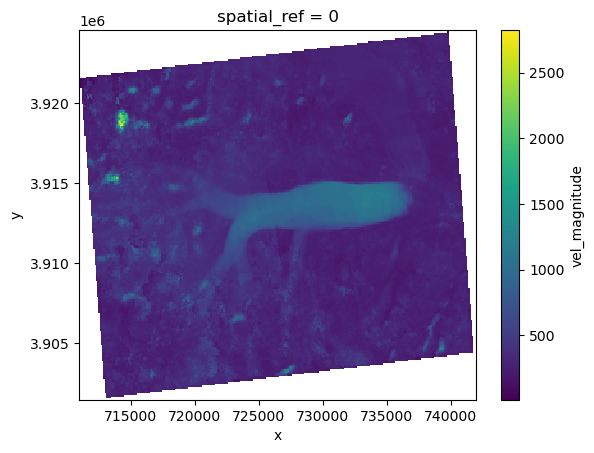

In [14]:
mean_vx_map = geotiffs_ds.x_vel.mean(dim='time')
mean_vy_map = geotiffs_ds.y_vel.mean(dim='time')
mean_speed_map = geotiffs_ds.vel_magnitude.mean(dim='time')

mean_speed_map.plot()

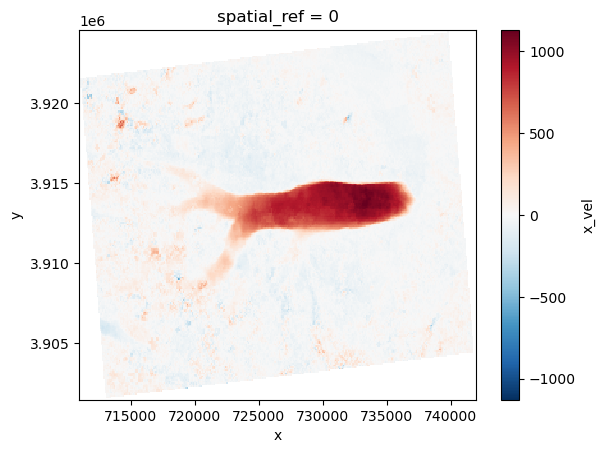

In [15]:
mean_vx_map.plot()

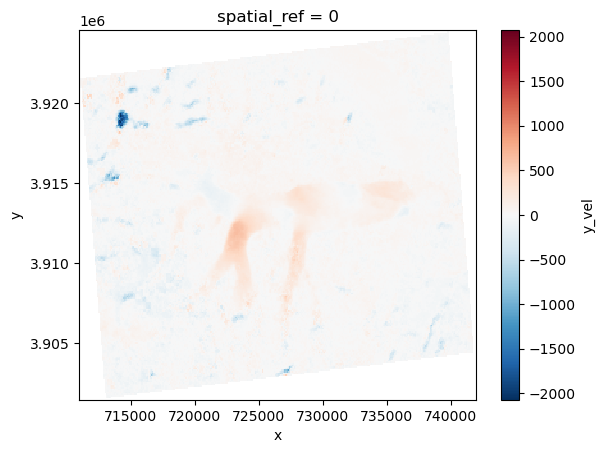

In [16]:
mean_vy_map.plot()

Looking at these plots we can see that the first two appear very similar; this indicates that magnitude of the velocity strongly matches the x velocity and that the effect of the velocity in the y direction is much less.